In [138]:
import sys 
import time
import pandas as pd
import numpy as np
import re
import random
from itertools import combinations
import pcalg
import networkx as nx
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from clustering.sbd import sbd
import matplotlib.pyplot as plt

In [139]:
# Parameters
DATA_FILE = "../data/20200821_user-db_cpu-load_01.json"
TARGET_DATA = {"containers": "all",
               "services": ["throughput", "latency"],
               "nodes": ["node_cpu_seconds_total", "node_disk_io_now", "node_filesystem_avail_bytes", "node_memory_MemAvailable_bytes", "node_network_receive_bytes_total", "node_network_transmit_bytes_total"],
               "middlewares": "all"}
PLOTS_NUM = 240
SIGNIFICANCE_LEVEL = 0.01
THRESHOLD_CV = 0.001
THRESHOLD_DIST = 0.01

In [140]:
# Prepare data matrix
raw_data = pd.read_json(DATA_FILE)
#raw_data.head()
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target] or TARGET_DATA[target] == "all":
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1]) if target != "middlewares" else "container_name"].replace("gke-microservices-experi-default-pool-", "")
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float)[:, 1][:PLOTS_NUM]
data_df = data_df.round(4)
labels = {}
for i in range(len(data_df.columns)):
    labels[i] = data_df.columns[i]

containers_list = []
services_list = []
for v in labels.values():
    if re.match("^c-", v):
        container_name = v.split("_")[0].replace("c-", "")
        if container_name not in containers_list:
            containers_list.append(container_name)
    elif re.match("^s-", v):
        service_name = v.split("_")[0].replace("s-", "")
        if service_name not in services_list:
            services_list.append(service_name)
data_df

,c-carts_cpu_cfs_throttled_seconds_total,c-carts_fs_inodes_free,c-carts_network_transmit_bytes_total,c-carts_fs_writes_bytes_total,c-carts_network_transmit_errors_total,c-carts_network_receive_packets_dropped_total,c-carts_memory_swap,c-carts_fs_io_time_seconds_total,c-carts_network_receive_bytes_total,c-carts_memory_max_usage_bytes,...,m-user-db_mongodb_mongod_wiredtiger_cache_bytes,m-user-db_mongodb_mongod_metrics_repl_oplog_insert_bytes_total,m-user-db_go_memstats_heap_inuse_bytes,m-user-db_mongodb_asserts_total,m-user-db_promhttp_metric_handler_requests_total,m-user-db_mongodb_up,m-user-db_mongodb_mongod_wiredtiger_transactions_checkpoint_milliseconds_total,m-user-db_mongodb_mongod_storage_engine,m-user-db_mongodb_mongod_metrics_repl_executor_queue,m-user-db_mongodb_mongod_wiredtiger_cache_overhead_percent
0,0.0000,0.0,96017.8774,0.0,0.0,0.0,0.0,0.0,79632.0511,318603264.0,...,184142.0,0.0,4636672.0,0.0,0.1333,1.0,0.0000,0.0,0.0,8.0
1,0.0000,0.0,74693.3639,0.0,0.0,0.0,0.0,0.0,61650.3914,318603264.0,...,184142.0,0.0,4227072.0,0.0,0.1333,1.0,0.1778,0.0,0.0,8.0
2,0.0000,0.0,91724.0452,0.0,0.0,0.0,0.0,0.0,75445.4004,318603264.0,...,184142.0,0.0,4489216.0,0.0,0.1333,1.0,0.1778,0.0,0.0,8.0
3,0.0000,0.0,91986.2928,0.0,0.0,0.0,0.0,0.0,76395.8939,318603264.0,...,184142.0,0.0,3170304.0,0.0,0.1333,1.0,0.1778,0.0,0.0,8.0
4,0.0013,0.0,92377.3343,0.0,0.0,0.0,0.0,0.0,76155.2729,318603264.0,...,184142.0,0.0,3514368.0,0.0,0.1333,1.0,0.0000,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0009,0.0,97289.7952,0.0,0.0,0.0,0.0,0.0,80474.2673,318603264.0,...,184142.0,0.0,3178496.0,0.0,0.1333,1.0,0.1556,0.0,0.0,8.0
236,0.0017,0.0,93123.0575,0.0,0.0,0.0,0.0,0.0,77223.5148,318603264.0,...,184142.0,0.0,4292608.0,0.0,0.1333,1.0,0.0000,0.0,0.0,8.0
237,0.0009,0.0,88287.8381,0.0,0.0,0.0,0.0,0.0,74302.7902,318603264.0,...,184142.0,0.0,4603904.0,0.0,0.1333,1.0,0.1778,0.0,0.0,8.0
238,0.0010,0.0,83724.1699,0.0,0.0,0.0,0.0,0.0,69865.7116,318603264.0,...,184142.0,0.0,3366912.0,0.0,0.1333,1.0,0.1778,0.0,0.0,8.0


## Reduce metrics

In [141]:
reduced_df = pd.DataFrame()
metrics_dimension = {}
clustering_info = {}
# Reduce metrics of container and middleware
for con in containers_list:
    con_df = data_df.loc[:, data_df.columns.str.startswith(("c-{}_".format(con), "m-{}_".format(con)))]
    metrics_dimension[con] = [len(con_df.columns)]
    # Reduce by CV
    n_metrics = 0
    for col in con_df.columns:
        data = data_df[col].values
        mean = data.mean()
        std = data.std()
        if mean == 0. and std == 0.:
            cv = 0
        else:
            cv = std / mean
        if cv >= THRESHOLD_CV:
            n_metrics += 1
            reduced_df[col] = data_df[col]
        else:
            con_df = con_df.drop(col, axis=1)
    metrics_dimension[con].append(n_metrics)
    # Reduce by clustering
    series = con_df.values.T
    dist = pdist(series, metric=sbd)
    dist_matrix = squareform(dist)
    z = linkage(dist, method="single", metric=sbd)
    labels = fcluster(z, t=THRESHOLD_DIST, criterion="distance")
    metrics_dimension[con].append(labels.max())
    cluster_dict = {}
    for i, v in enumerate(labels):
        if v not in cluster_dict:
            cluster_dict[v] = [i]
        else:
            cluster_dict[v].append(i)
    remove_list = []
    for c in cluster_dict:
        cluster_metrics = cluster_dict[c]
        if len(cluster_metrics) == 2:
            # Select the representative metric at random
            shuffle_list = random.sample(cluster_metrics, len(cluster_metrics))
            clustering_info[con_df.columns[shuffle_list[0]]] = [con_df.columns[shuffle_list[1]]]
            remove_list.append(con_df.columns[shuffle_list[1]])
        elif len(cluster_metrics) > 2:
            # Select medoid as the representative metric
            distances = []
            for met1 in cluster_metrics:
                dist_sum = 0
                for met2 in cluster_metrics:
                    if met1 != met2:
                        dist_sum += dist_matrix[met1][met2]
                distances.append(dist_sum)
            medoid = cluster_metrics[np.argmin(distances)]
            clustering_info[con_df.columns[medoid]] = []
            for r in cluster_metrics:
                if r != medoid:
                    remove_list.append(con_df.columns[r])
                    clustering_info[con_df.columns[medoid]].append(con_df.columns[r])                 
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)
# Join metrics of services and nodes
reduced_df = pd.concat([reduced_df, data_df.loc[:, data_df.columns.str.startswith(("s-", "n-"))]], axis=1)

In [142]:
reduced_df

,c-carts_cpu_cfs_throttled_seconds_total,c-carts_cpu_cfs_throttled_periods_total,c-carts_memory_failures_total,c-carts_network_transmit_packets_total,c-catalogue_cpu_cfs_throttled_seconds_total,c-catalogue_network_receive_bytes_total,c-catalogue_cpu_cfs_throttled_periods_total,c-front-end_memory_failures_total,c-front-end_cpu_usage_seconds_total,c-orders_cpu_cfs_throttled_seconds_total,...,n-66a015a7-eq47_network_transmit_bytes_total,n-66a015a7-eq47_memory_MemAvailable_bytes,n-66a015a7-eq47_disk_io_now,n-66a015a7-eq47_filesystem_avail_bytes,n-gke-microservices-experi-control-pool-7934097e-2c0k_cpu_seconds_total,n-gke-microservices-experi-control-pool-7934097e-2c0k_network_receive_bytes_total,n-gke-microservices-experi-control-pool-7934097e-2c0k_network_transmit_bytes_total,n-gke-microservices-experi-control-pool-7934097e-2c0k_memory_MemAvailable_bytes,n-gke-microservices-experi-control-pool-7934097e-2c0k_disk_io_now,n-gke-microservices-experi-control-pool-7934097e-2c0k_filesystem_avail_bytes
0,0.0000,0.0000,1.3318,462.2055,0.0004,62911.3286,0.0208,283.6029,0.2720,0.0000,...,564558.4889,3.027599e+09,0.0,3.851769e+11,1.9784,918896.7356,1.658908e+06,2.494951e+09,0.0,3.899964e+11
1,0.0000,0.0000,1.2737,359.1642,0.0004,62677.6602,0.0440,321.0383,0.2742,0.0000,...,549045.5990,3.029561e+09,0.0,3.851748e+11,1.9817,899766.9607,1.619190e+06,2.486694e+09,0.0,3.899959e+11
2,0.0000,0.0000,2.0243,441.9768,0.0000,60436.8469,0.0240,518.0952,0.2316,0.0000,...,539876.4444,3.027374e+09,0.0,3.851725e+11,1.9838,869268.8444,1.573706e+06,2.481242e+09,0.0,3.899953e+11
3,0.0000,0.0000,2.0132,445.9989,0.0000,59646.1324,0.0193,536.7358,0.2764,0.0000,...,544053.9556,3.028333e+09,0.0,3.851703e+11,1.9814,859483.9885,1.545852e+06,2.479526e+09,0.0,3.899948e+11
4,0.0013,0.0222,1.4657,447.0541,0.0000,41889.7892,0.0000,523.0705,0.2345,0.0000,...,551064.2903,3.027644e+09,0.0,3.851681e+11,1.9776,866003.8890,1.562249e+06,2.478035e+09,0.0,3.899942e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0009,0.0209,1.3763,468.8560,0.0000,45293.9060,0.0000,387.9167,0.2103,0.0000,...,567870.2222,3.028562e+09,0.0,3.851702e+11,1.9827,917535.3556,1.653444e+06,6.652219e+09,0.0,3.900219e+11
236,0.0017,0.0375,1.2376,449.6936,0.0000,63394.0646,0.0000,507.4695,0.2703,0.0000,...,543103.7778,3.028570e+09,0.0,3.851682e+11,1.9796,909331.3778,1.640704e+06,6.628528e+09,0.0,3.900213e+11
237,0.0009,0.0201,0.0000,427.1991,0.0000,57191.1717,0.0000,400.9643,0.2153,0.0005,...,516896.0222,3.027243e+09,0.0,3.851662e+11,1.9768,861145.7079,1.547018e+06,6.632215e+09,0.0,3.900208e+11
238,0.0010,0.0225,0.0000,402.6435,0.0000,56916.9227,0.0000,363.6791,0.2463,0.0006,...,498985.0444,3.027517e+09,0.0,3.851640e+11,1.9769,813191.8444,1.470554e+06,6.604100e+09,0.0,3.900203e+11


In [143]:
total_before = 0
total_cv = 0
total_clustering = 0
for con in metrics_dimension:
    total_before += metrics_dimension[con][0]
    total_cv += metrics_dimension[con][1]
    total_clustering += metrics_dimension[con][2]
metrics_dimension["total"] = [total_before, total_cv, total_clustering]
metrics_dimension

{'carts': [55, 12, 4],
 'catalogue': [53, 11, 3],
 'front-end': [53, 15, 2],
 'orders': [55, 12, 4],
 'payment': [55, 8, 2],
 'queue-master': [55, 10, 2],
 'shipping': [55, 10, 2],
 'user': [55, 12, 3],
 'orders-db': [175, 65, 17],
 'catalogue-db': [51, 8, 3],
 'rabbitmq': [51, 9, 1],
 'carts-db': [175, 60, 16],
 'session-db': [49, 4, 1],
 'user-db': [178, 56, 18],
 'total': [1115, 292, 78]}

## Build causal graph

In [144]:
labels = {}
for i in range(len(reduced_df.columns)):
    labels[i] = reduced_df.columns[i]
print(labels)

{0: 'c-carts_cpu_cfs_throttled_seconds_total', 1: 'c-carts_cpu_cfs_throttled_periods_total', 2: 'c-carts_memory_failures_total', 3: 'c-carts_network_transmit_packets_total', 4: 'c-catalogue_cpu_cfs_throttled_seconds_total', 5: 'c-catalogue_network_receive_bytes_total', 6: 'c-catalogue_cpu_cfs_throttled_periods_total', 7: 'c-front-end_memory_failures_total', 8: 'c-front-end_cpu_usage_seconds_total', 9: 'c-orders_cpu_cfs_throttled_seconds_total', 10: 'c-orders_network_transmit_bytes_total', 11: 'c-orders_cpu_cfs_throttled_periods_total', 12: 'c-orders_cpu_usage_seconds_total', 13: 'c-payment_network_transmit_bytes_total', 14: 'c-payment_memory_working_set_bytes', 15: 'c-queue-master_memory_failures_total', 16: 'c-queue-master_cpu_usage_seconds_total', 17: 'c-shipping_memory_failures_total', 18: 'c-shipping_network_transmit_packets_total', 19: 'c-user_cpu_cfs_throttled_seconds_total', 20: 'c-user_cpu_cfs_throttled_periods_total', 21: 'c-user_memory_rss', 22: 'c-orders-db_memory_failures_t

In [145]:
containers_metrics = {}
for c in containers_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^c-{}_".format(c), v):
            nodes.append(k)
    containers_metrics[c] = nodes
print(containers_metrics)

services_metrics = {}
for s in services_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^s-{}_".format(s), v):
            nodes.append(k)
    services_metrics[s] = nodes
print(services_metrics)

{'carts': [0, 1, 2, 3], 'catalogue': [4, 5, 6], 'front-end': [7, 8], 'orders': [9, 10, 11, 12], 'payment': [13, 14], 'queue-master': [15, 16], 'shipping': [17, 18], 'user': [19, 20, 21], 'orders-db': [22, 23], 'catalogue-db': [39, 40, 41], 'rabbitmq': [42], 'carts-db': [43, 44], 'session-db': [59], 'user-db': [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]}
{'carts': [78, 79], 'catalogue': [80, 81], 'front-end': [82, 83], 'orders': [84, 85], 'payment': [86, 87], 'shipping': [88, 89], 'user': [90, 91]}


## 事前知識

In [146]:
# Communicating dependency
com_deps = {
    "front-end": ["orders", "carts", "user", "catalogue"],
    "catalogue": ["front-end", "catalogue-db"],
    "catalogue-db": ["catalogue"],
    "orders": ["front-end", "orders-db", "carts", "user", "payement", "shipping"],
    "orders-db": ["orders"],
    "user": ["front-end", "user-db", "orders"],
    "user-db": ["user"],
    "payment": ["orders"],
    "shipping": ["orders", "rabbitmq"],
    "queue-master": ["rabbitmq"],
    "rabbitmq": ["shipping", "queue-master"],
    "carts": ["front-end", "carts-db", "orders"],
    "carts-db": ["carts"],
    "session-db": ["front-end"]
}

# Service-containers relations
service_containers = {
    "carts": ["carts", "carts-db"],
    "payment": ["payment"],
    "shipping": ["shipping"],
    "front-end": ["front-end"],
    "user": ["user", "user-db"],
    "catalogue": ["catalogue", "catalogue-db"],
    "orders": ["orders", "orders-db"]
}

# Share host
nodes_containers = {}
for node, containers in raw_data["mappings"].dropna()["nodes-containers"].items():
    for container in containers:
        nodes_containers[container] = node.replace("gke-microservices-experi-default-pool-", "")
nodes_containers

{'shipping': '66a015a7-w0i8',
 'user-db': '66a015a7-w0i8',
 'orders': '66a015a7-w0i8',
 'carts': '66a015a7-w0i8',
 'session-db': '66a015a7-w0i8',
 'catalogue': '66a015a7-eq47',
 'user': '66a015a7-eq47',
 'queue-master': '66a015a7-eq47',
 'orders-db': '66a015a7-eq47',
 'front-end': '66a015a7-g7qj',
 'catalogue-db': '66a015a7-g7qj',
 'rabbitmq': '66a015a7-g7qj',
 'payment': '66a015a7-i5rl',
 'carts-db': '66a015a7-i5rl'}

In [147]:
no_deps_container_pair = []
for i, j in combinations(containers_list, 2):
    if j not in com_deps[i] and nodes_containers[i] != nodes_containers[j]:
        no_deps_container_pair.append([i, j])
print("No dependence container pairs: {}".format(len(no_deps_container_pair)))

no_deps_service_pair = []
for i, j in combinations(services_list, 2):
    has_comm = False
    for c1 in service_containers[i]:
        for c2 in service_containers[j]:
            if c2 in com_deps[c1]:
                has_comm = True
    if not has_comm:
        no_deps_service_pair.append([i, j])

print("No dependence service pairs: {}".format(len(no_deps_service_pair)))

No dependence container pairs: 60
No dependence service pairs: 14


In [148]:
no_paths = []
for pair in no_deps_container_pair:
    for i in containers_metrics[pair[0]]:
        for j in containers_metrics[pair[1]]:
            no_paths.append([i, j])
            
for pair in no_deps_service_pair:
    for i in services_metrics[pair[0]]:
        for j in services_metrics[pair[1]]:
            no_paths.append([i, j])
print(len(no_paths))

501


## Fisher-Z検定

In [149]:
# Prepare data matrix
dm = reduced_df.values
print("Shape of data matrix: {}".format(dm.shape))

# Prepare init graph
init_g = nx.Graph()
node_ids = range(len(reduced_df.columns))
init_g.add_nodes_from(node_ids)
for (i, j) in combinations(node_ids, 2):
    init_g.add_edge(i, j)
print("Number of edges in complete graph : {}".format(init_g.number_of_edges()))
for no_path in no_paths:
    init_g.remove_edge(no_path[0], no_path[1])
print("Number of edges in init graph : {}".format(init_g.number_of_edges()))
#agraph = nx.nx_agraph.to_agraph(init_g).draw(prog='sfdp', format='png')
#Image(agraph)

from citest.fisher_z import ci_test_fisher_z
cm = np.corrcoef(dm.T)

start = time.time()
(G, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_fisher_z,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 corr_matrix=cm,
                                 init_graph=init_g)
G = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")

Shape of data matrix: (240, 122)
Number of edges in complete graph : 7381
Number of edges in init graph : 6880


/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/citest/fisher_z.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  return np.log1p(2 * r / (1 - r))
/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/citest/fisher_z.py:22: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(2 * r / (1 - r))
/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/citest/fisher_z.py:22: RuntimeWarning: invalid value encountered in log1p
  return np.l

Elapsed time:2.281/sec


Number of nodes: 85


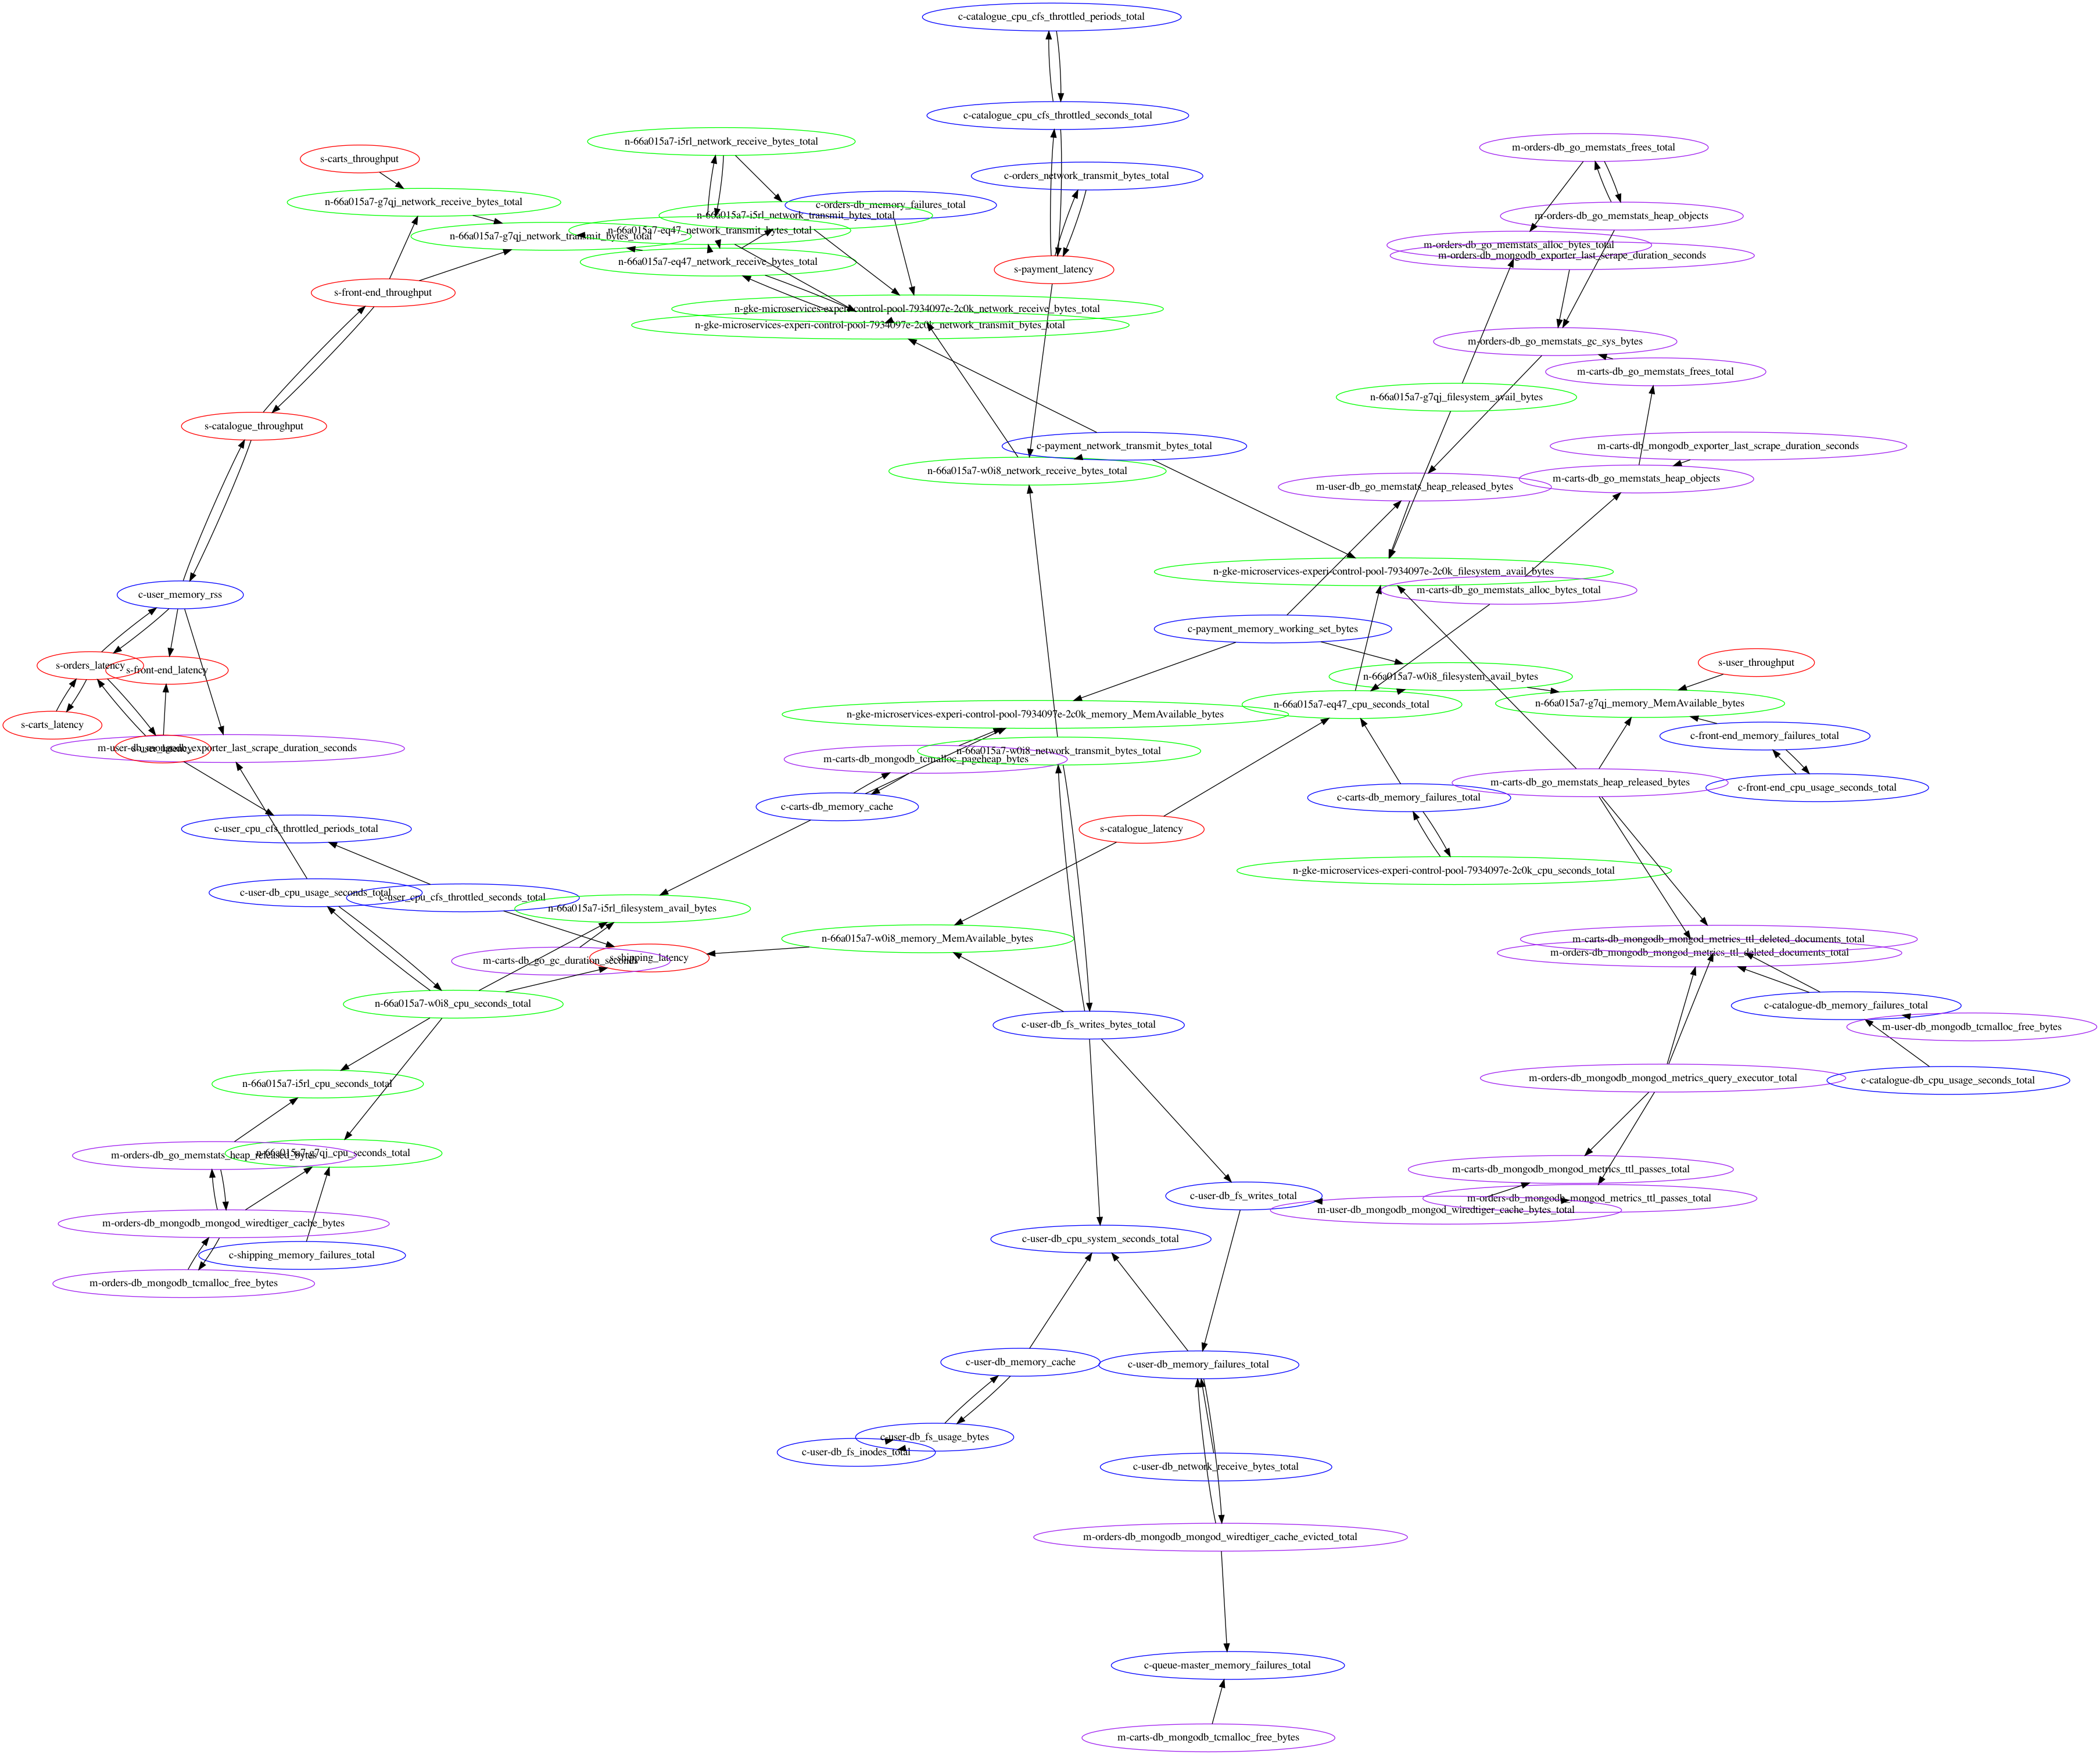

In [150]:
# Relabel
G = nx.relabel_nodes(G, labels)

# Exclude nodes that have no path to "s-front-end_latency" for visualization
remove_nodes = []
undirected_G = G.to_undirected()
for node in G.nodes():
    if not nx.has_path(undirected_G, node, "s-front-end_latency"):
        remove_nodes.append(node)
        continue
    if re.match("^s-", node):
        color = "red"
    elif re.match("^c-", node):
        color = "blue"
    elif re.match("^m-", node):
        color = "purple"
    else:
        color = "green"
    G.nodes[node]["color"] = color
G.remove_nodes_from(remove_nodes)
print("Number of nodes: {}".format(G.number_of_nodes()))

from IPython.display import Image, SVG, display

# prog=[‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’] 
agraph = nx.nx_agraph.to_agraph(G).draw(prog='sfdp', format='png')
Image(agraph)